In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from dna_features_viewer import GraphicFeature, GraphicRecord
import matplotlib.text as mtext
from matplotlib.colors import TwoSlopeNorm
import textwrap
from core import bw_color_palette
from tqdm import tqdm
from joblib import Parallel, delayed
from matplotlib.colors import TwoSlopeNorm


In [3]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.size'] = 11

In [4]:
%%time
predictions = pd.read_parquet('../data3/processed/refseq_1k_predictions.pq')
clusters = pd.read_parquet('../data3/interim/refseq_cover_clusters.pq')
seq_id_accessions = pd.read_parquet('../data/interim/seq_id_accessions.pq')
df_true_df = pd.read_parquet('../data/interim/defense_finder_genes_genomes.pq')
df_homolog_df = pd.read_parquet('../data/interim/defense_finder_homologs_profile_names.pq')
df_homolog_df = df_homolog_df.merge(seq_id_accessions, how='inner', on='seq_id')
seq_assemblies = (pd.read_csv('../data/interim/seq_assemblies.csv', 
                             names=['product_accession', 'seq_id', 'seq', 'assembly_stub'])
                  .drop(columns=['seq']))

CPU times: user 7min 27s, sys: 1min 7s, total: 8min 35s
Wall time: 8min 25s


In [6]:
higlight_df = pd.read_csv('../data3/external/candidate_refseq_pfams_annot_v2.csv')

In [14]:
select_gene_df = predictions.merge(higlight_df[['protein_context_id',
                                                'pfam_description']], how='inner', on='protein_context_id')

In [8]:
n_sample = 3

In [9]:
ft_dir = '../data/genome_downloads/ft/'
ft_dict = {f.split('.')[0]: os.path.join(ft_dir, f) for f in os.listdir(ft_dir) if f.endswith('.txt')}

In [10]:
region_width = 10_000

In [11]:
quick_true_df = (df_true_df[['protein_accession', 'gene_name']]
                 .groupby('protein_accession')
                 .head(1)
                 .rename(columns={'protein_accession': 'product_accession', 
                                  'gene_name': 'true_defense_name'}))

In [12]:
quick_homolog_df = (df_homolog_df[['protein_accession', 'gene_name']]
                    .groupby('protein_accession')
                    .head(1)
                    .rename(columns={'protein_accession': 'product_accession', 
                                     'gene_name': 'homolog_defense_name'}))

In [15]:
gene_assembly_list = list()
for _, query_row in select_gene_df.iterrows():
    print(query_row['product_accession'])
    query_cluster = query_row['cluster_id']
    gene_assembly_list.append({'query': query_row['protein_context_id'],
                               'product_accession': query_row['product_accession'], 
                               'assembly_stub': query_row['assembly'].split('.')[0]})
    cluster_seq_ids = clusters.loc[(clusters['cluster_id'] == query_cluster), 'seq_id']
    print('# cluster seqs:', len(cluster_seq_ids))
    if len(cluster_seq_ids):
        cluster_assemblies = (seq_assemblies.loc[seq_assemblies['seq_id'].isin(cluster_seq_ids), :]
                              .groupby('seq_id')
                              .sample(n=1, random_state=7))
        for _, row in cluster_assemblies.iterrows():
            gene_assembly_list.append({'query': query_row['protein_context_id'],
                                       'product_accession': row['product_accession'], 
                                       'assembly_stub': row['assembly_stub']})
        

WP_138643969.1
# cluster seqs: 10
WP_120181747.1
# cluster seqs: 24
WP_070612333.1
# cluster seqs: 69
WP_068616620.1
# cluster seqs: 4
WP_116852361.1
# cluster seqs: 8
WP_261736184.1
# cluster seqs: 132
WP_261736184.1
# cluster seqs: 132
WP_221050791.1
# cluster seqs: 101
WP_225011210.1
# cluster seqs: 9
WP_017732743.1
# cluster seqs: 177


In [16]:
gene_assembly_df = pd.DataFrame(gene_assembly_list)

In [17]:
## Count defense proteins and mobile elements in region
feature_count_list = list()
for query, query_df in gene_assembly_df.groupby('query'):
    print(query)
    for i, cluster_row in tqdm(query_df.reset_index(drop=True).iterrows(), total=len(query_df)):
        ft_file = ft_dict[cluster_row['assembly_stub']]
        ft_df = pd.read_table(ft_file)
        center_row = (ft_df[(ft_df['product_accession'] == cluster_row['product_accession']) & 
                            (ft_df['# feature'] == 'CDS')]
                      .head(1)
                      .squeeze())
        if (center_row['strand'] == '+'):
            region_start, region_end = center_row['start'] - region_width, center_row['start'] + region_width
        else:
            region_start, region_end = center_row['end'] - region_width, center_row['end'] + region_width
        region_df = (ft_df[(ft_df['# feature'] != 'gene') & 
                           (ft_df['start'] > region_start) & 
                           (ft_df['end'] < region_end) & 
                           (ft_df['start'] < ft_df['end']) & 
                           (ft_df['genomic_accession'] == center_row['genomic_accession'])
                          ]
                          .merge(quick_true_df, how='left', on='product_accession')
                          .merge(quick_homolog_df, how='left', on='product_accession')
                          .reset_index(drop=True))
        cluster_row['n_true_defense'] = (~region_df['true_defense_name'].isna()).sum()
        cluster_row['n_defense_homologs'] = (~region_df['homolog_defense_name'].isna()).sum()
        cluster_row['n_mge'] = region_df['name'].str.contains('integrase|transposase|recombinase').sum()
        feature_count_list.append(cluster_row)

WP_017732743.1|NZ_ANNU01000041.1|33985|+


100%|██████████| 178/178 [04:36<00:00,  1.55s/it]


WP_068616620.1|NZ_CP016268.1|2737625|-


100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


WP_070612333.1|NZ_CP081916.1|5747616|+


100%|██████████| 70/70 [01:47<00:00,  1.54s/it]


WP_116852361.1|NZ_QTJV01000001.1|1473310|-


100%|██████████| 9/9 [00:14<00:00,  1.58s/it]


WP_120181747.1|NZ_MBTA01000023.1|243632|+


100%|██████████| 25/25 [00:38<00:00,  1.53s/it]


WP_138643969.1|NZ_VCKW01000018.1|39904|+


100%|██████████| 11/11 [00:17<00:00,  1.58s/it]


WP_221050791.1|NZ_AP024618.1|1539526|-


100%|██████████| 102/102 [02:37<00:00,  1.54s/it]


WP_225011210.1|NZ_JAILYM010000011.1|48900|+


100%|██████████| 10/10 [00:15<00:00,  1.51s/it]


WP_261736184.1|NZ_JALKQL010000005.1|418671|-


100%|██████████| 266/266 [06:34<00:00,  1.48s/it]


In [18]:
feature_count_df = (pd.concat(feature_count_list, axis=1).T
                    .drop_duplicates())

In [19]:
select_assemblies = (feature_count_df.sort_values(['n_true_defense', 'n_defense_homologs', 'n_mge'], 
                                                 ascending=False)
                    .groupby('query')
                    .head(n_sample*2))

In [20]:
def get_plot_name(row):
    if not pd.isna(row['true_defense_name']):
        return row['true_defense_name'].split('__')[1]
    elif not pd.isna(row['homolog_defense_name']):
        return row['homolog_defense_name'].split('__')[1]
    elif row['name'] == 'hypothetical protein':
        return None
    else:
        return row['name']

In [21]:
def get_plot_color(row):
    if not pd.isna(row['true_defense_name']):
        return bw_color_palette[0]
    elif not pd.isna(row['homolog_defense_name']):
        return bw_color_palette[1]
    elif ('integrase' in row['name']) or ('transposase' in row['name']) or ('recombinase' in row['name']):
        return 'dimgray'
    else:
        return 'darkgrey'
    

In [22]:
norm = TwoSlopeNorm(vmin=predictions['mean_log_odds'].min(), 
                    vcenter=0, 
                    vmax=predictions['mean_log_odds'].max())
cmap = plt.get_cmap('PiYG')

In [23]:
def get_plot_color_pred(row, cmap=cmap, norm=norm):
    if not pd.isna(row['mean_log_odds']):
        return cmap(norm(row['mean_log_odds']))
    else:
        return 'white'

In [24]:
def remove_all_clipping(fig):
    """
    Recursively remove clipping for all artists in a figure.
    """
    for artist in fig.get_children():
        # For container artists, recursively call this function
        if hasattr(artist, 'get_children') and callable(artist.get_children):
            remove_all_clipping(artist)
        
        # For artists with a 'set_clip_on' method, call it with False
        if hasattr(artist, 'set_clip_on') and callable(artist.set_clip_on):
            artist.set_clip_on(False)

In [26]:
query_pred_row

,protein_context_id,mean_log_odds,sd_log_odds,min_log_odds,max_log_odds,# feature,class,assembly,assembly_unit,seq_type,...,defense_homolog_name,defense_homolog,assembly_stub,defense_system_gene,defense_system,defense_system_protein,seq,seq_id,cluster_id,pfam_description
5,WP_261736184.1|NZ_JALKQL010000005.1|418671|-,8.034708,0.677986,7.189454,8.747545,CDS,with_protein,GCF_025397885.1,Primary Assembly,unplaced scaffold,...,None,False,GCF_025397885,None,None,False,MITTTNITLDIYADSIRDTDRLADLQSLIFGLYGEVGSVVTTAKKQ...,58dda2ac8269cfdef3a4106494b1ad5c82de0325b9dd20...,f0751ee6edc1b093b1371d3844b900927a846491f62395...,MazG C-terminal domain
6,WP_261736184.1|NZ_JALKQL010000005.1|418671|-,8.034708,0.677986,7.189454,8.747545,CDS,with_protein,GCF_025397885.1,Primary Assembly,unplaced scaffold,...,None,False,GCF_025397885,None,None,False,MITTTNITLDIYADSIRDTDRLADLQSLIFGLYGEVGSVVTTAKKQ...,58dda2ac8269cfdef3a4106494b1ad5c82de0325b9dd20...,f0751ee6edc1b093b1371d3844b900927a846491f62395...,MazG-like family


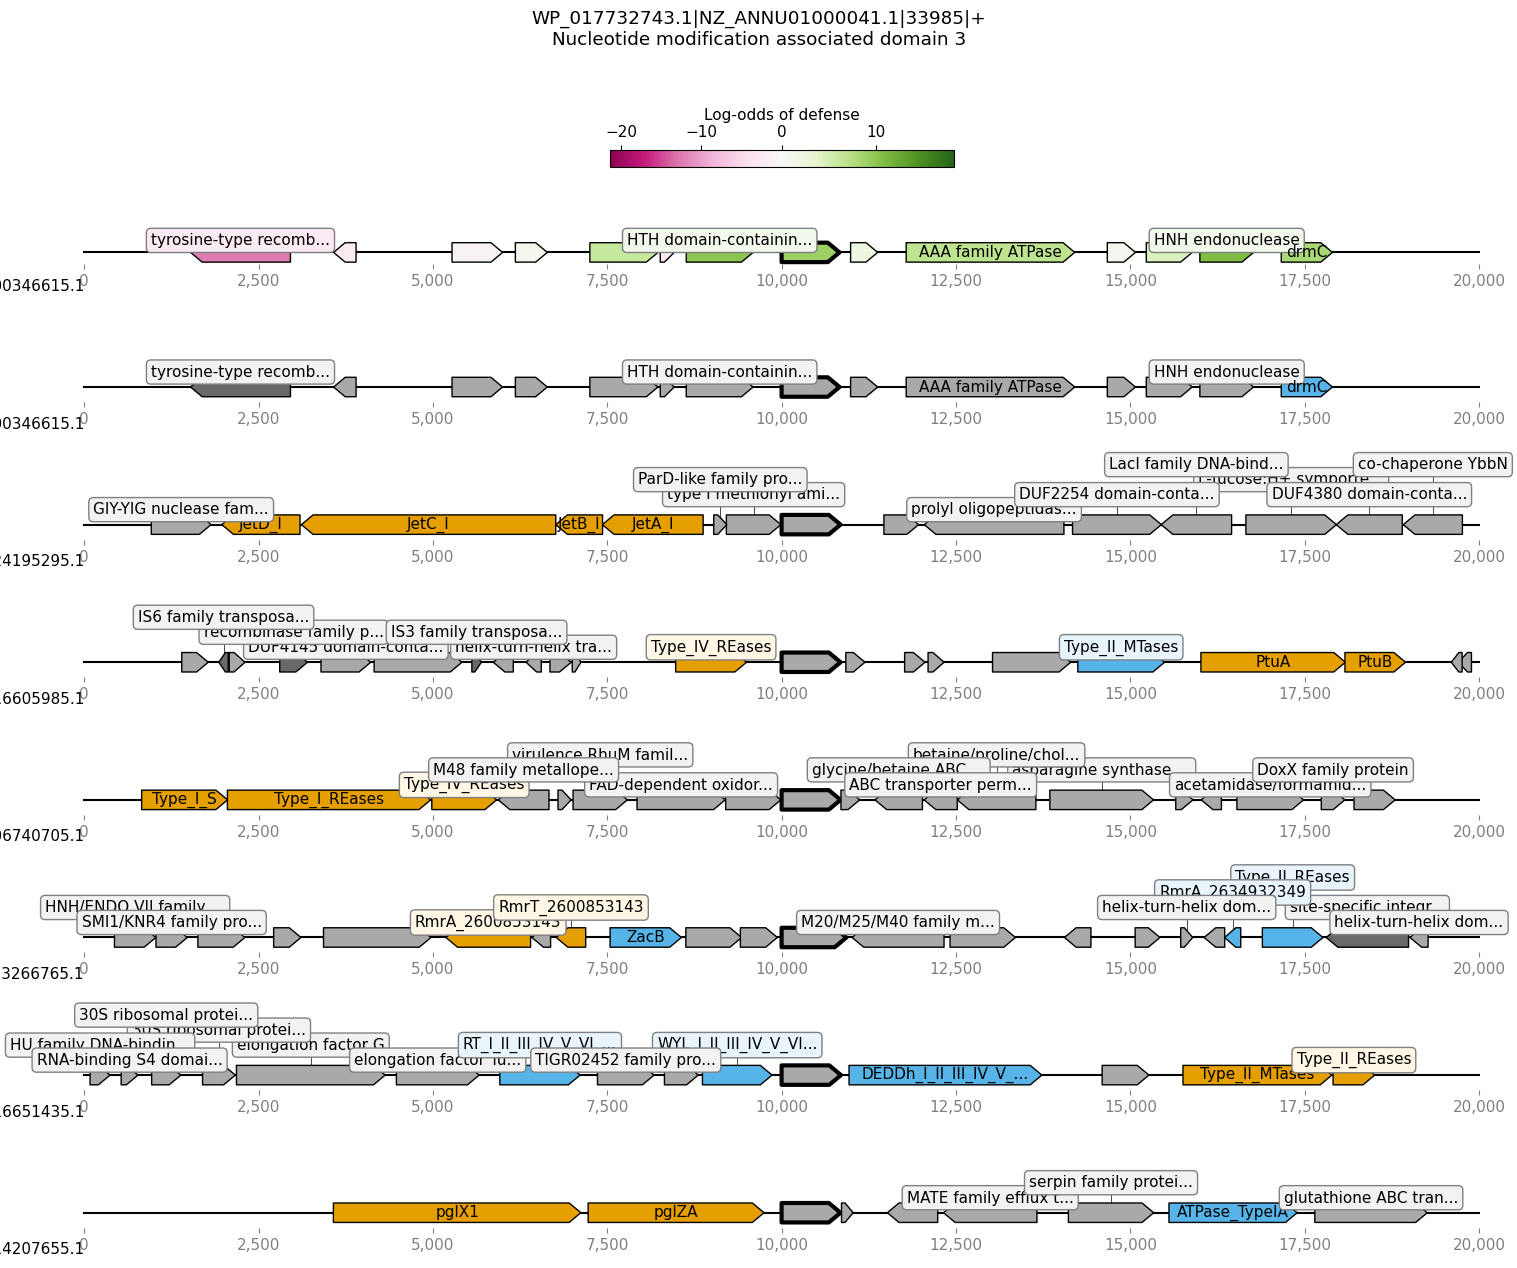

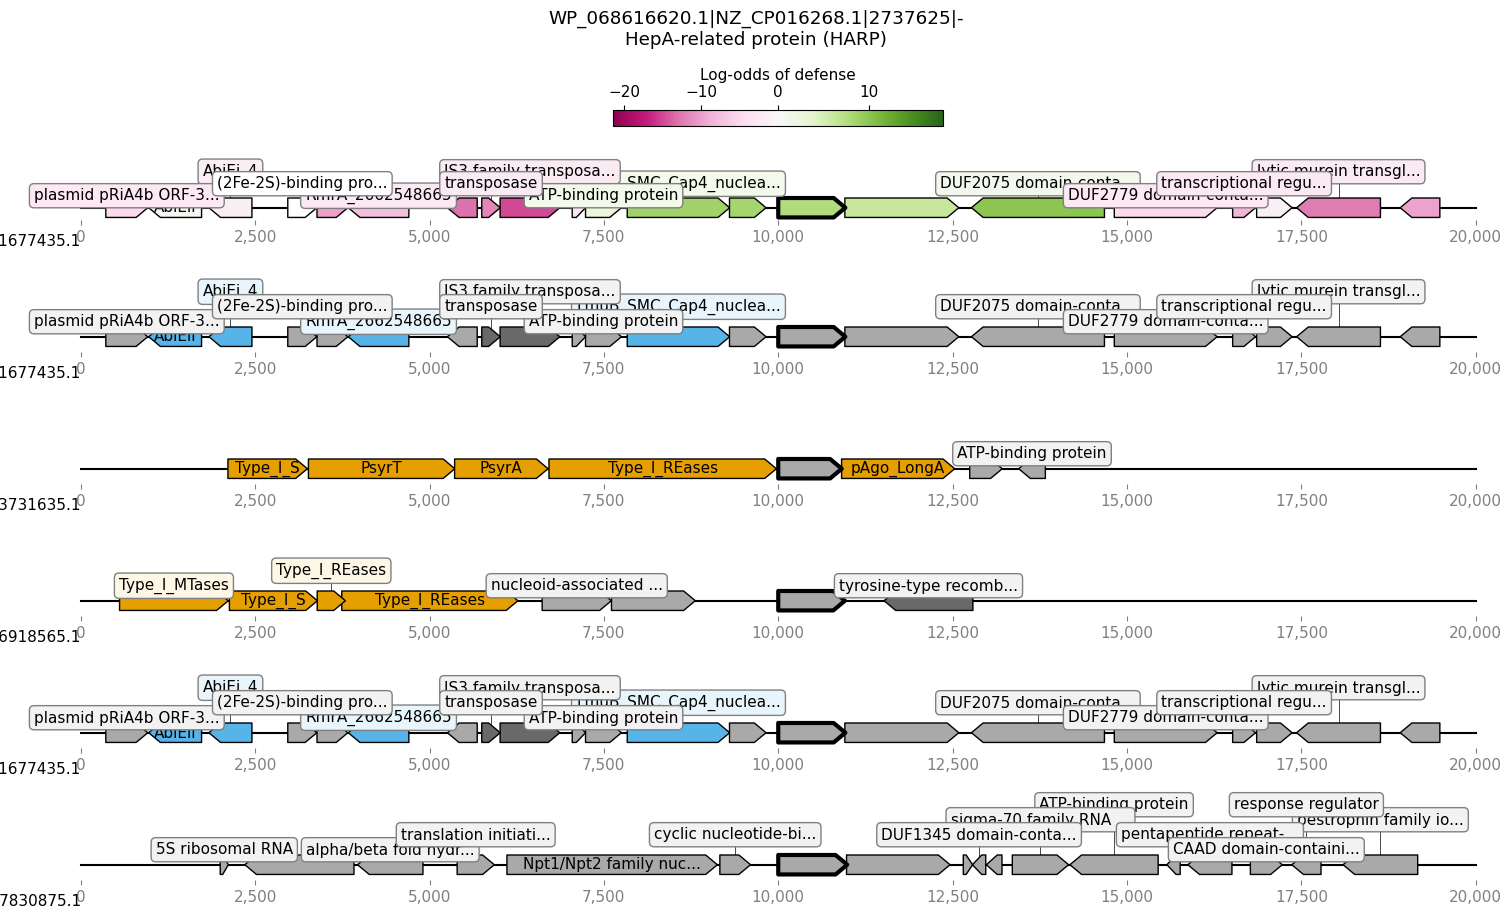

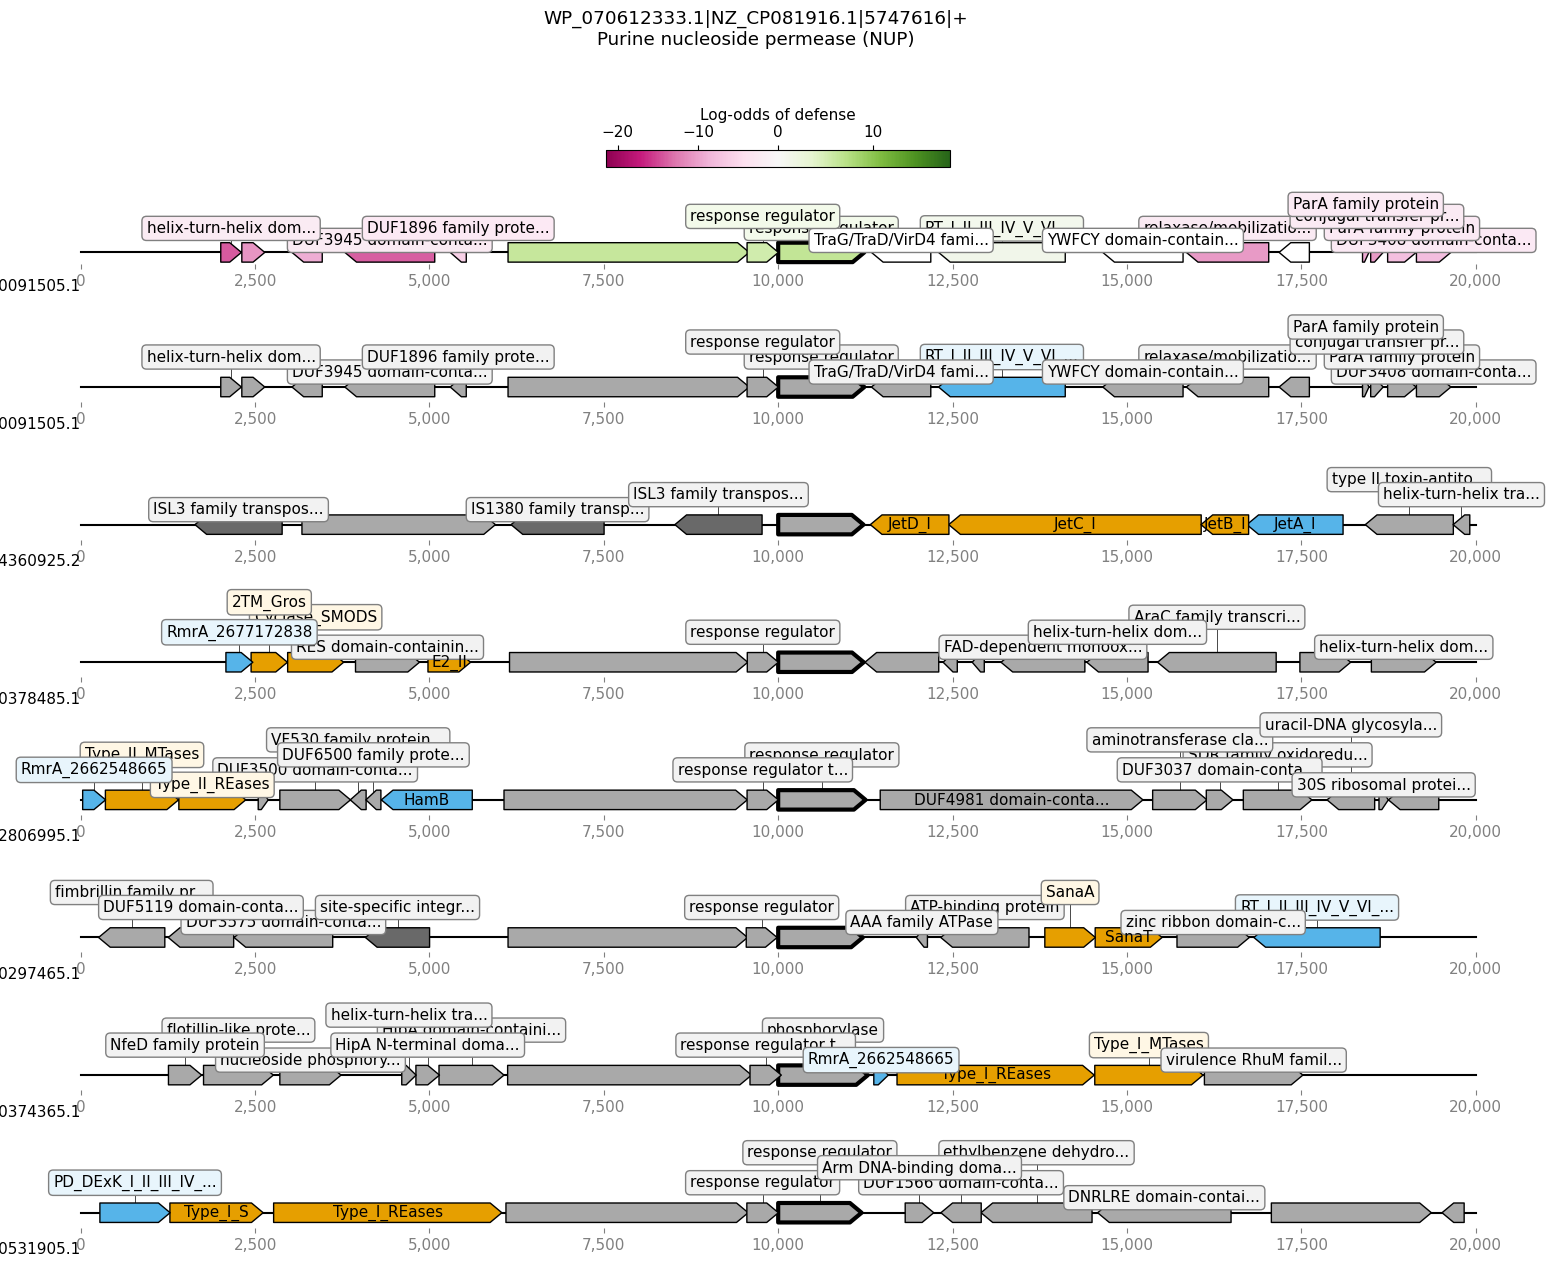

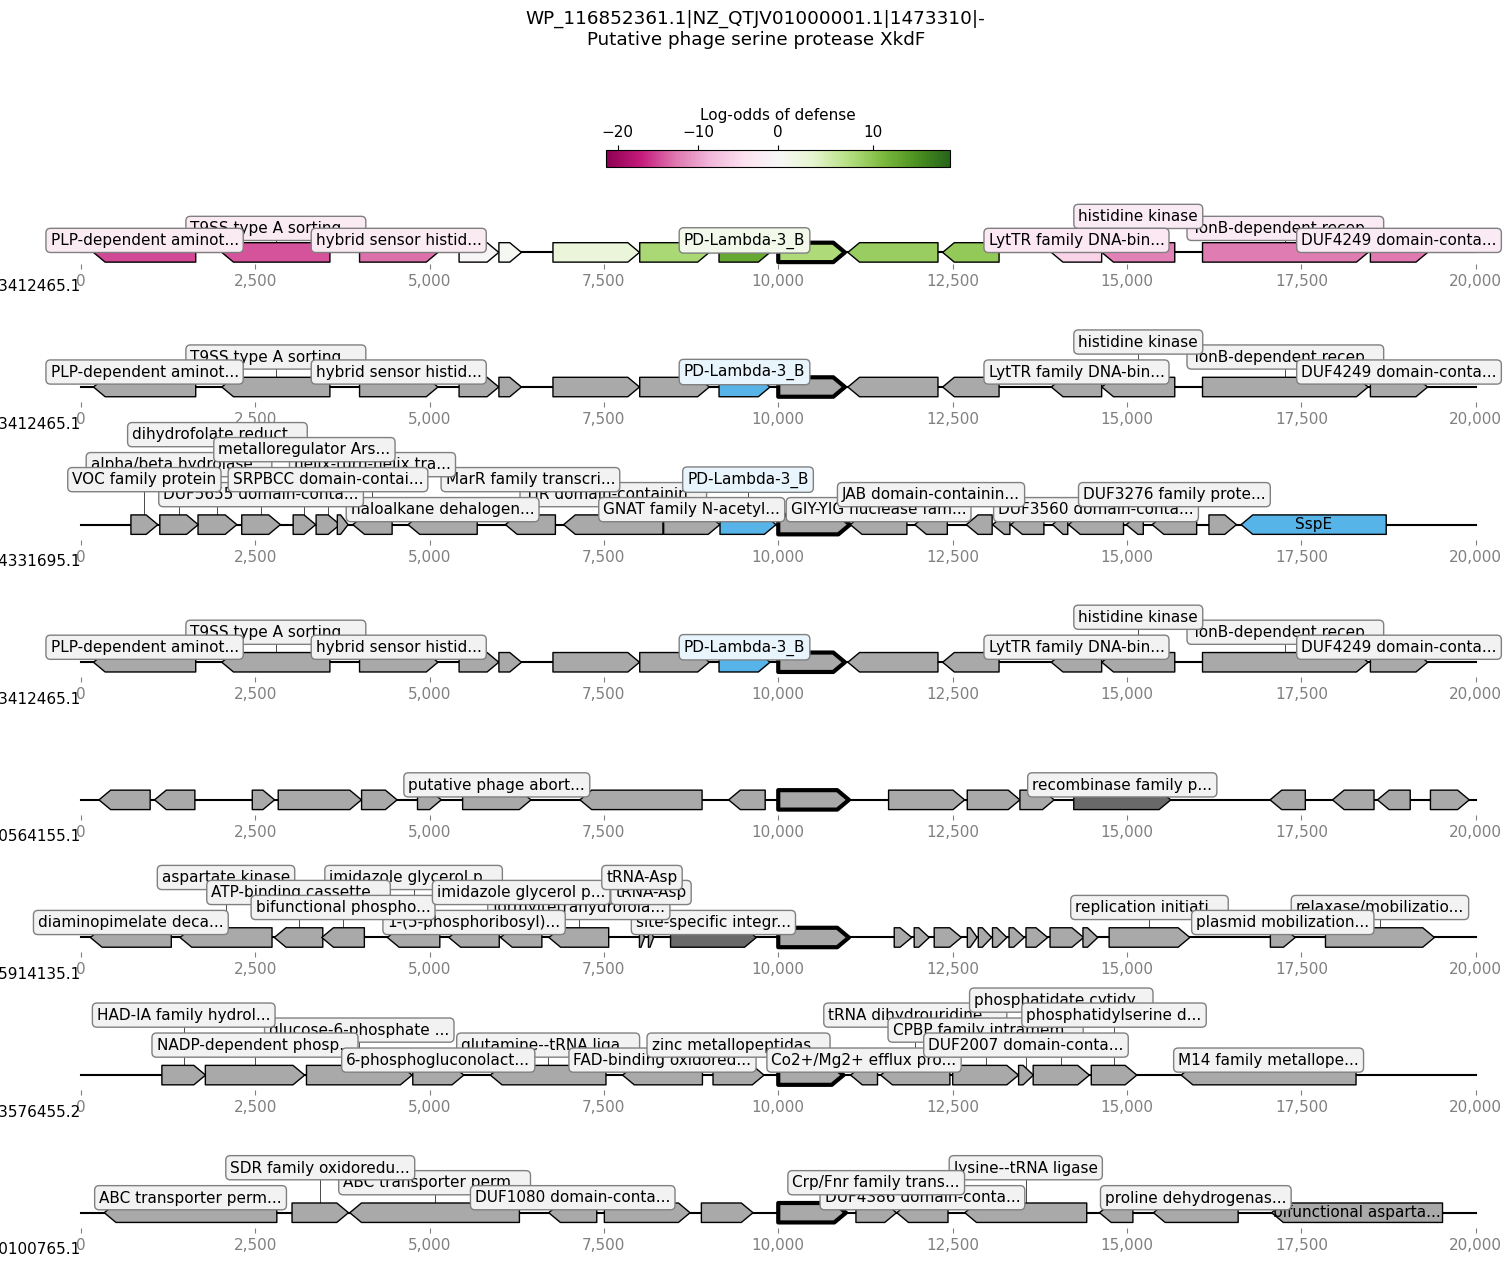

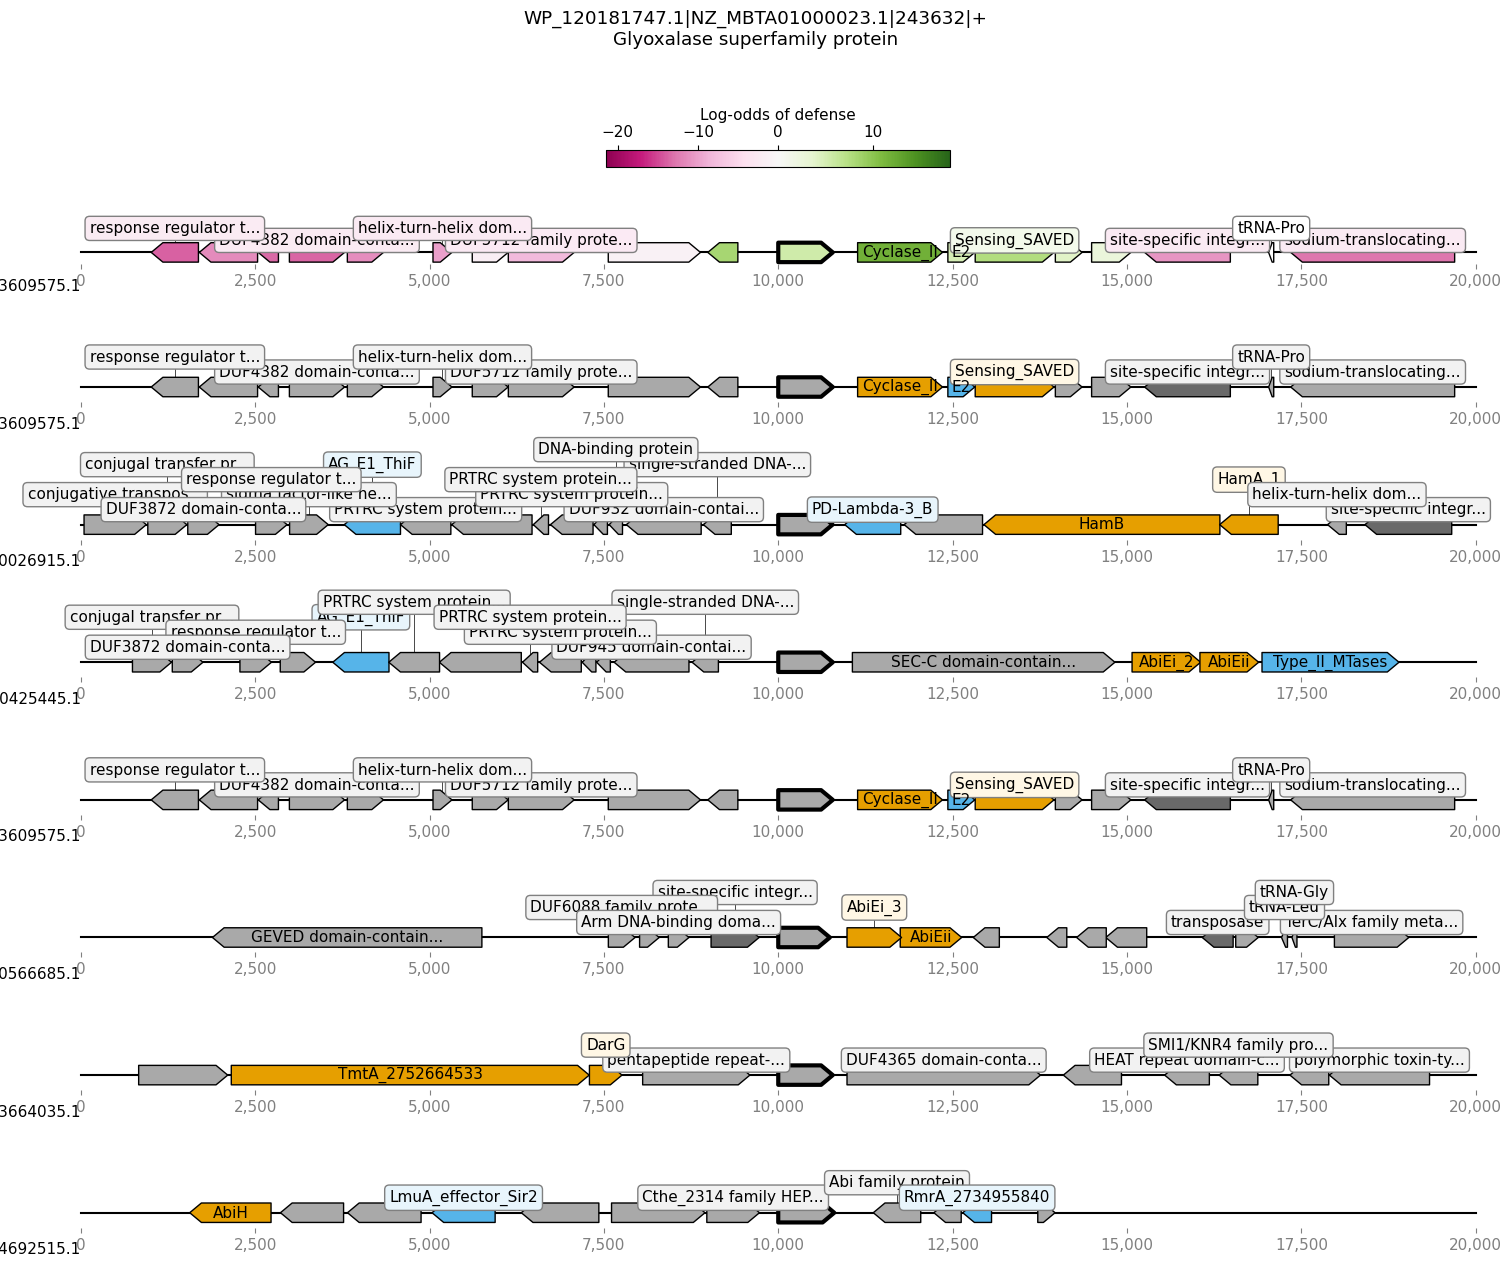

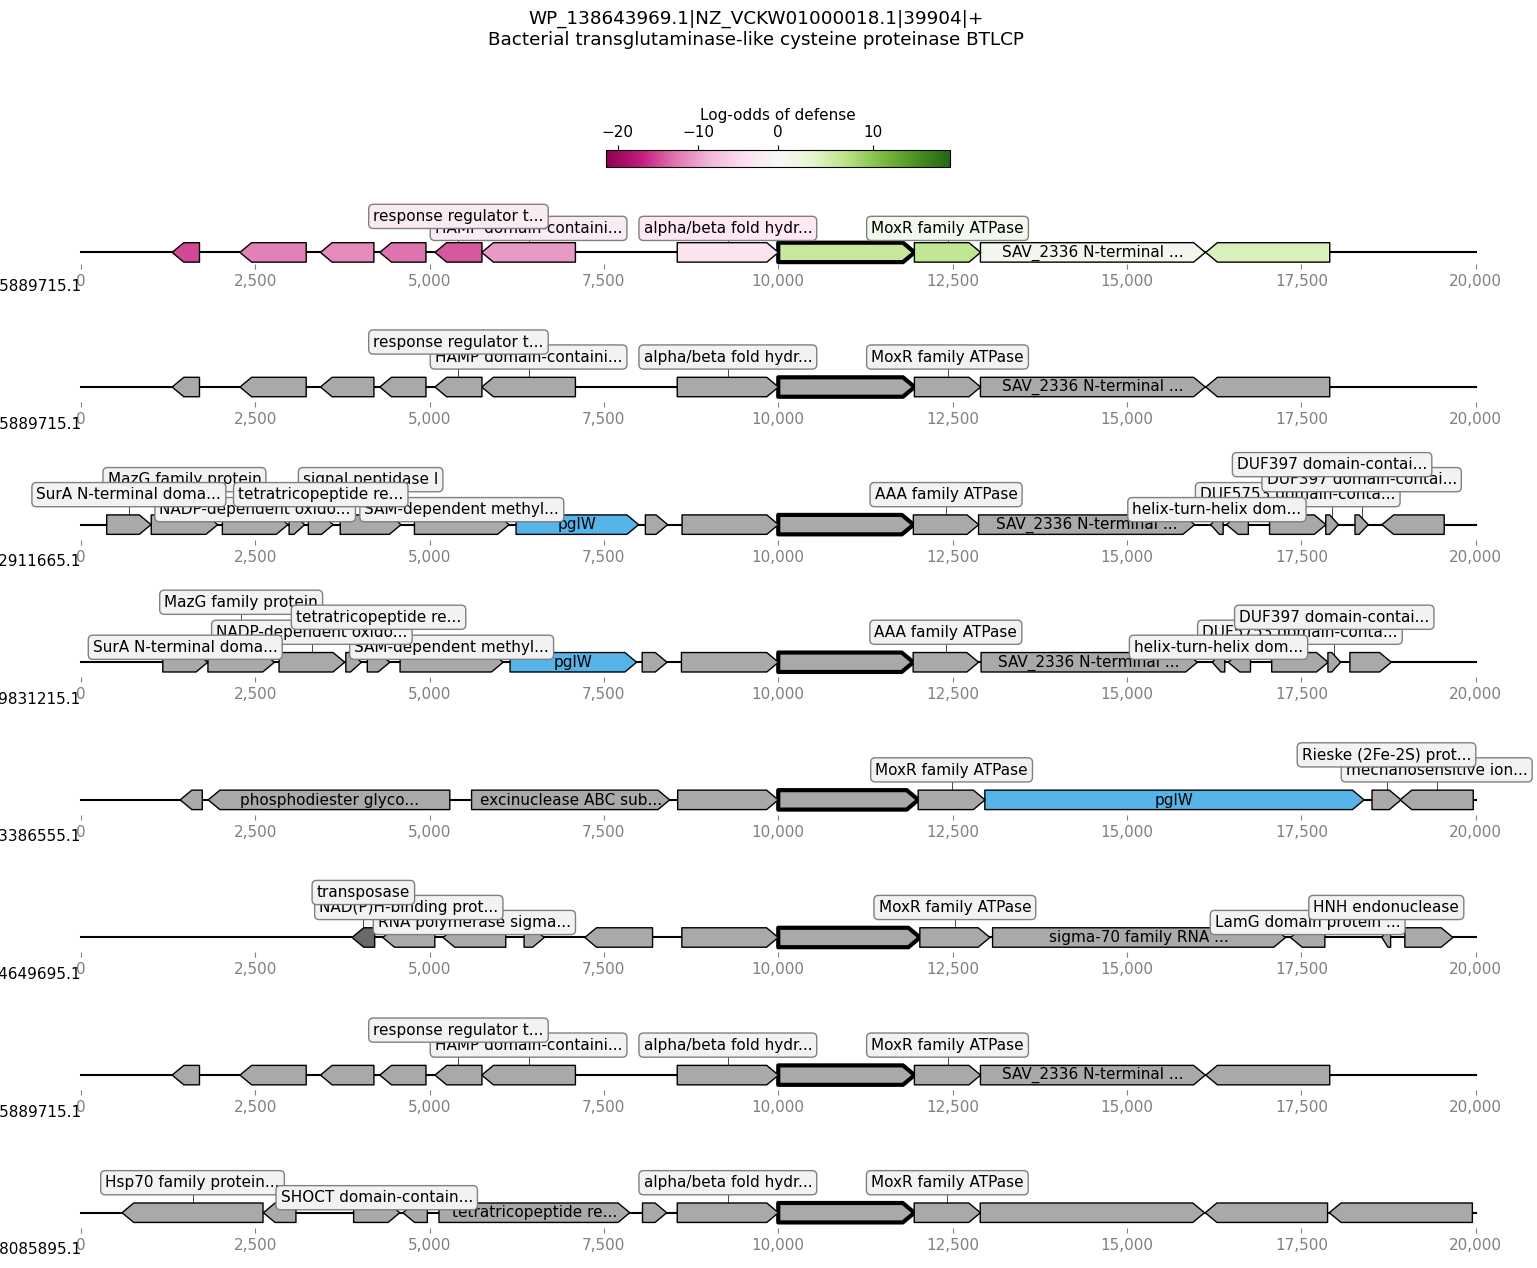

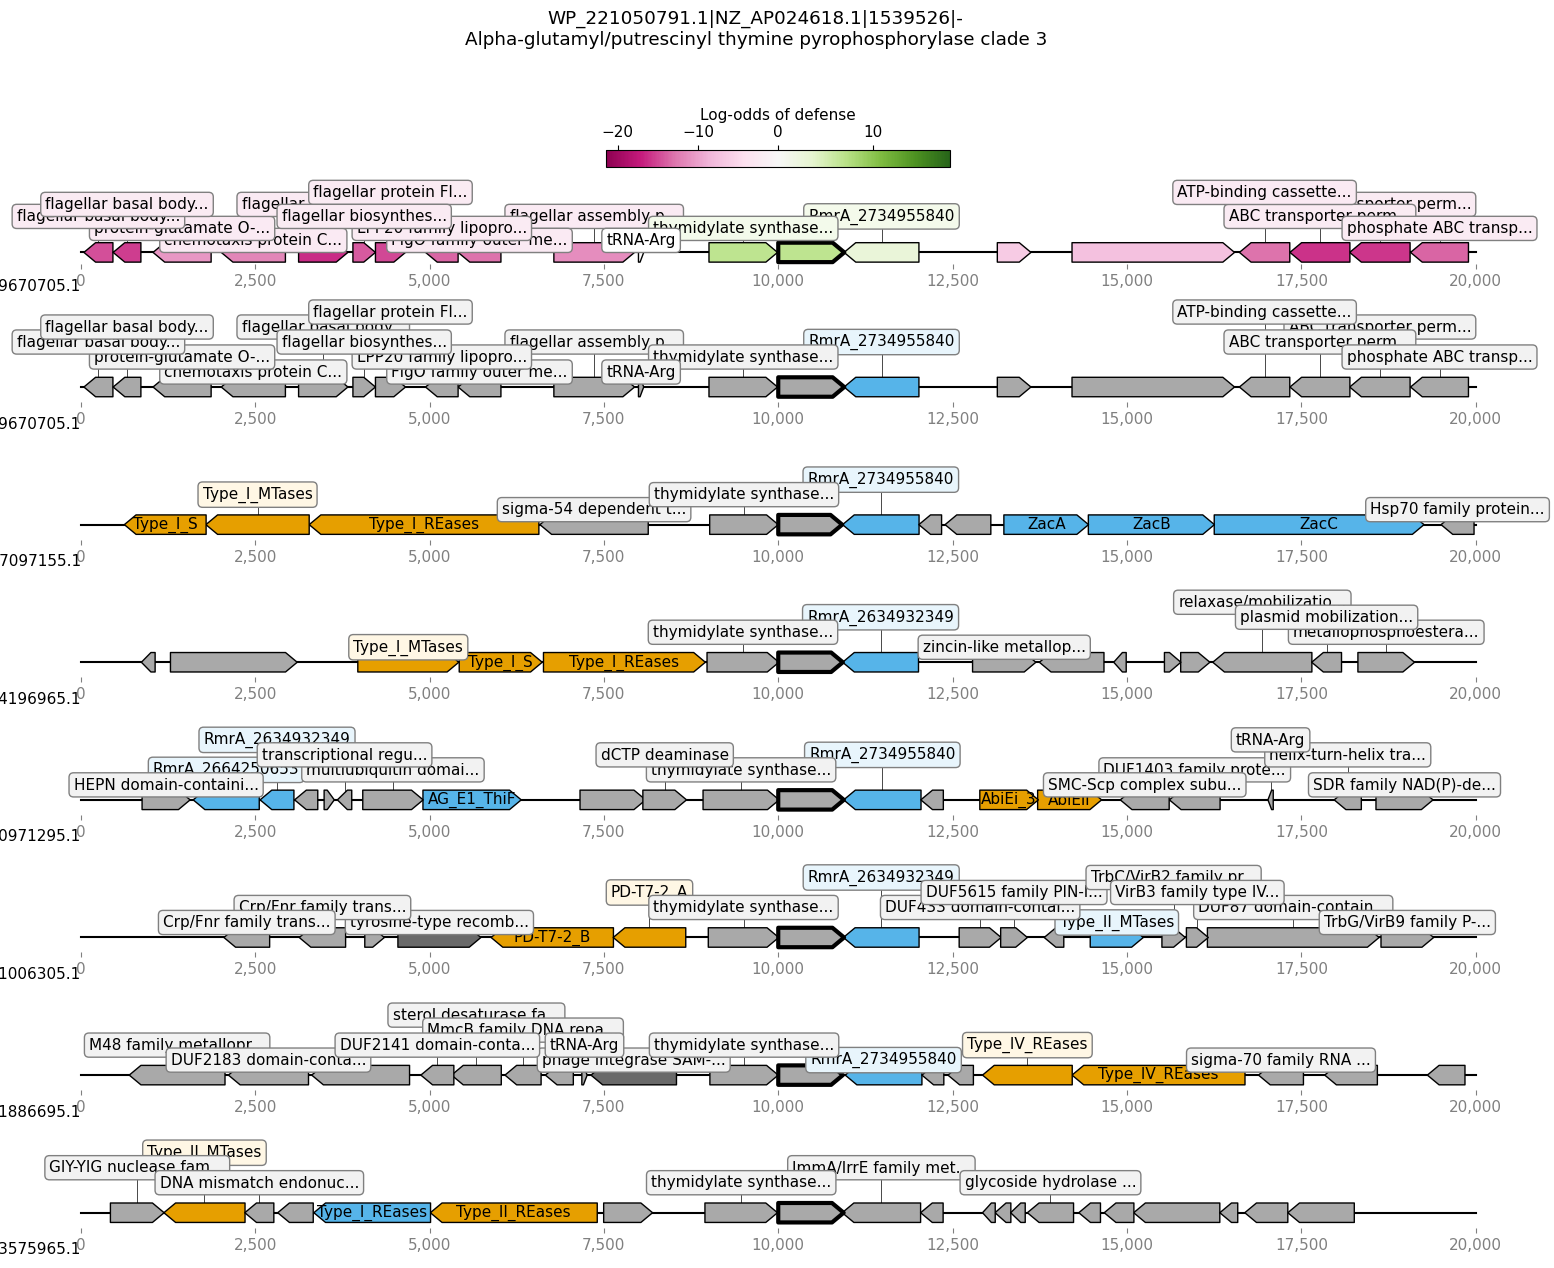

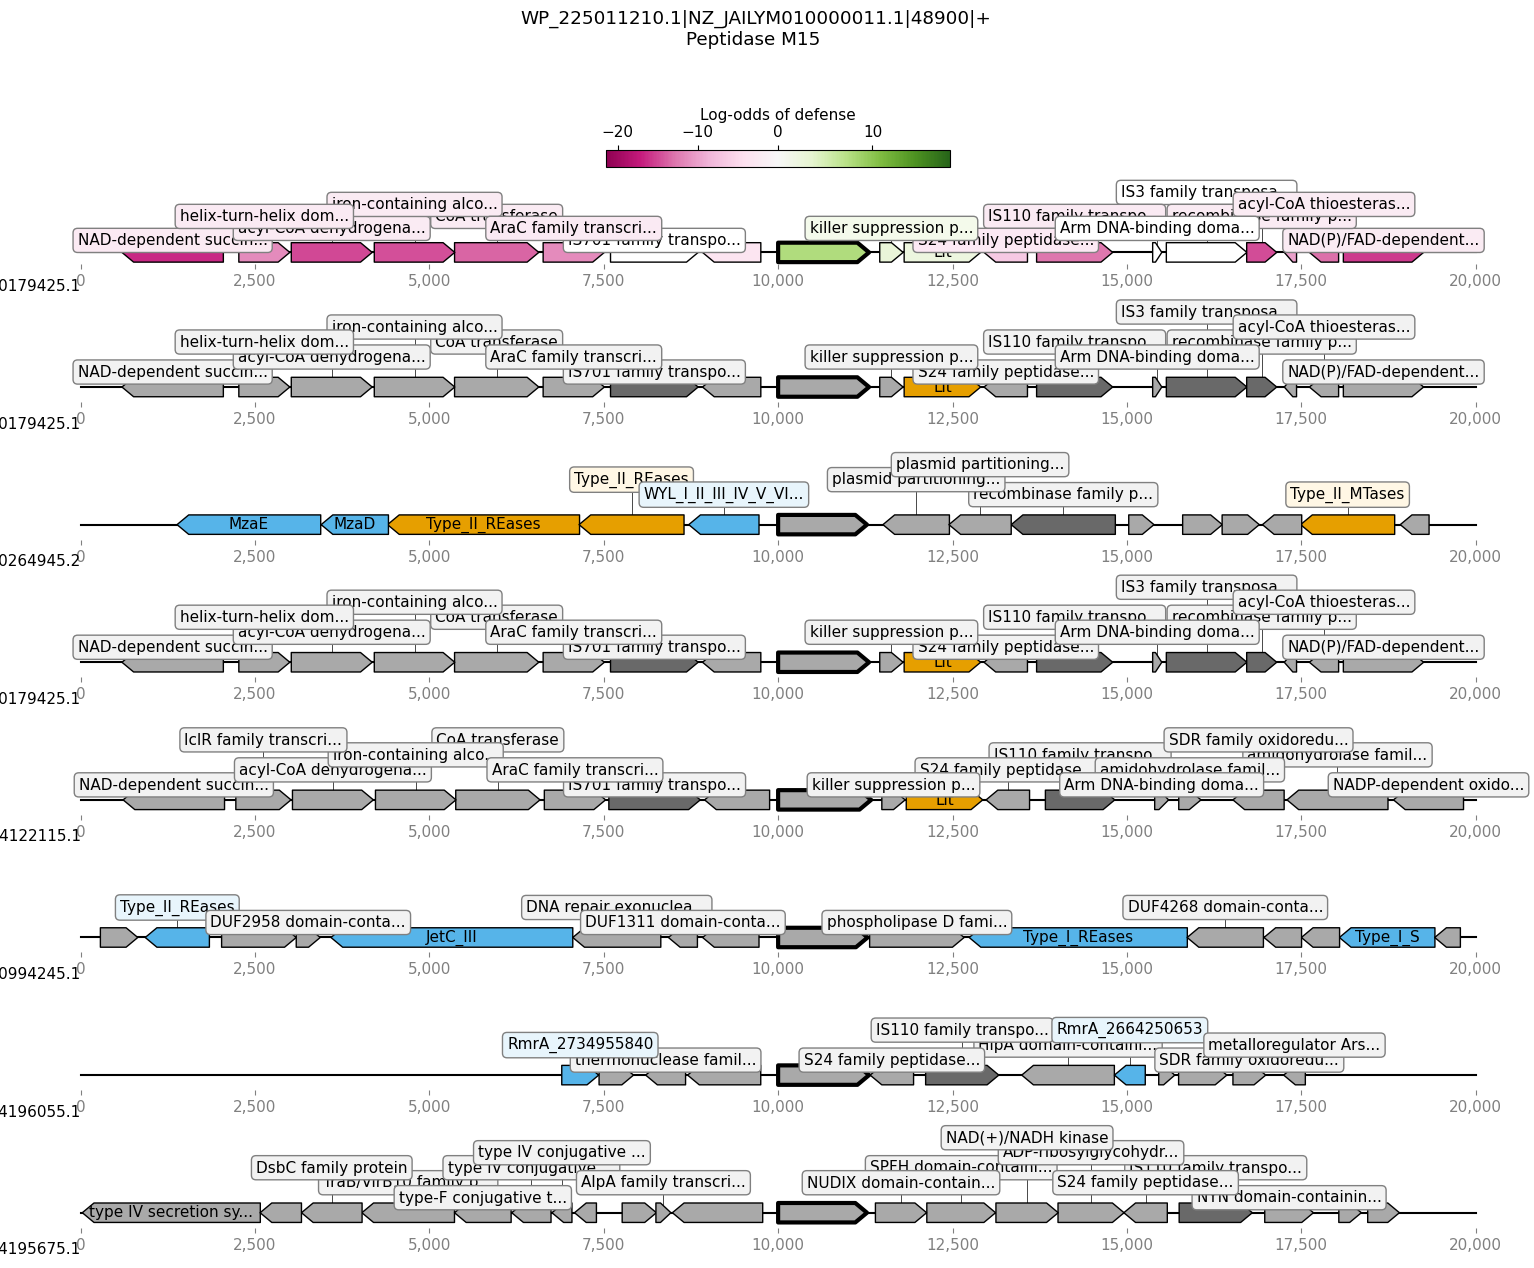

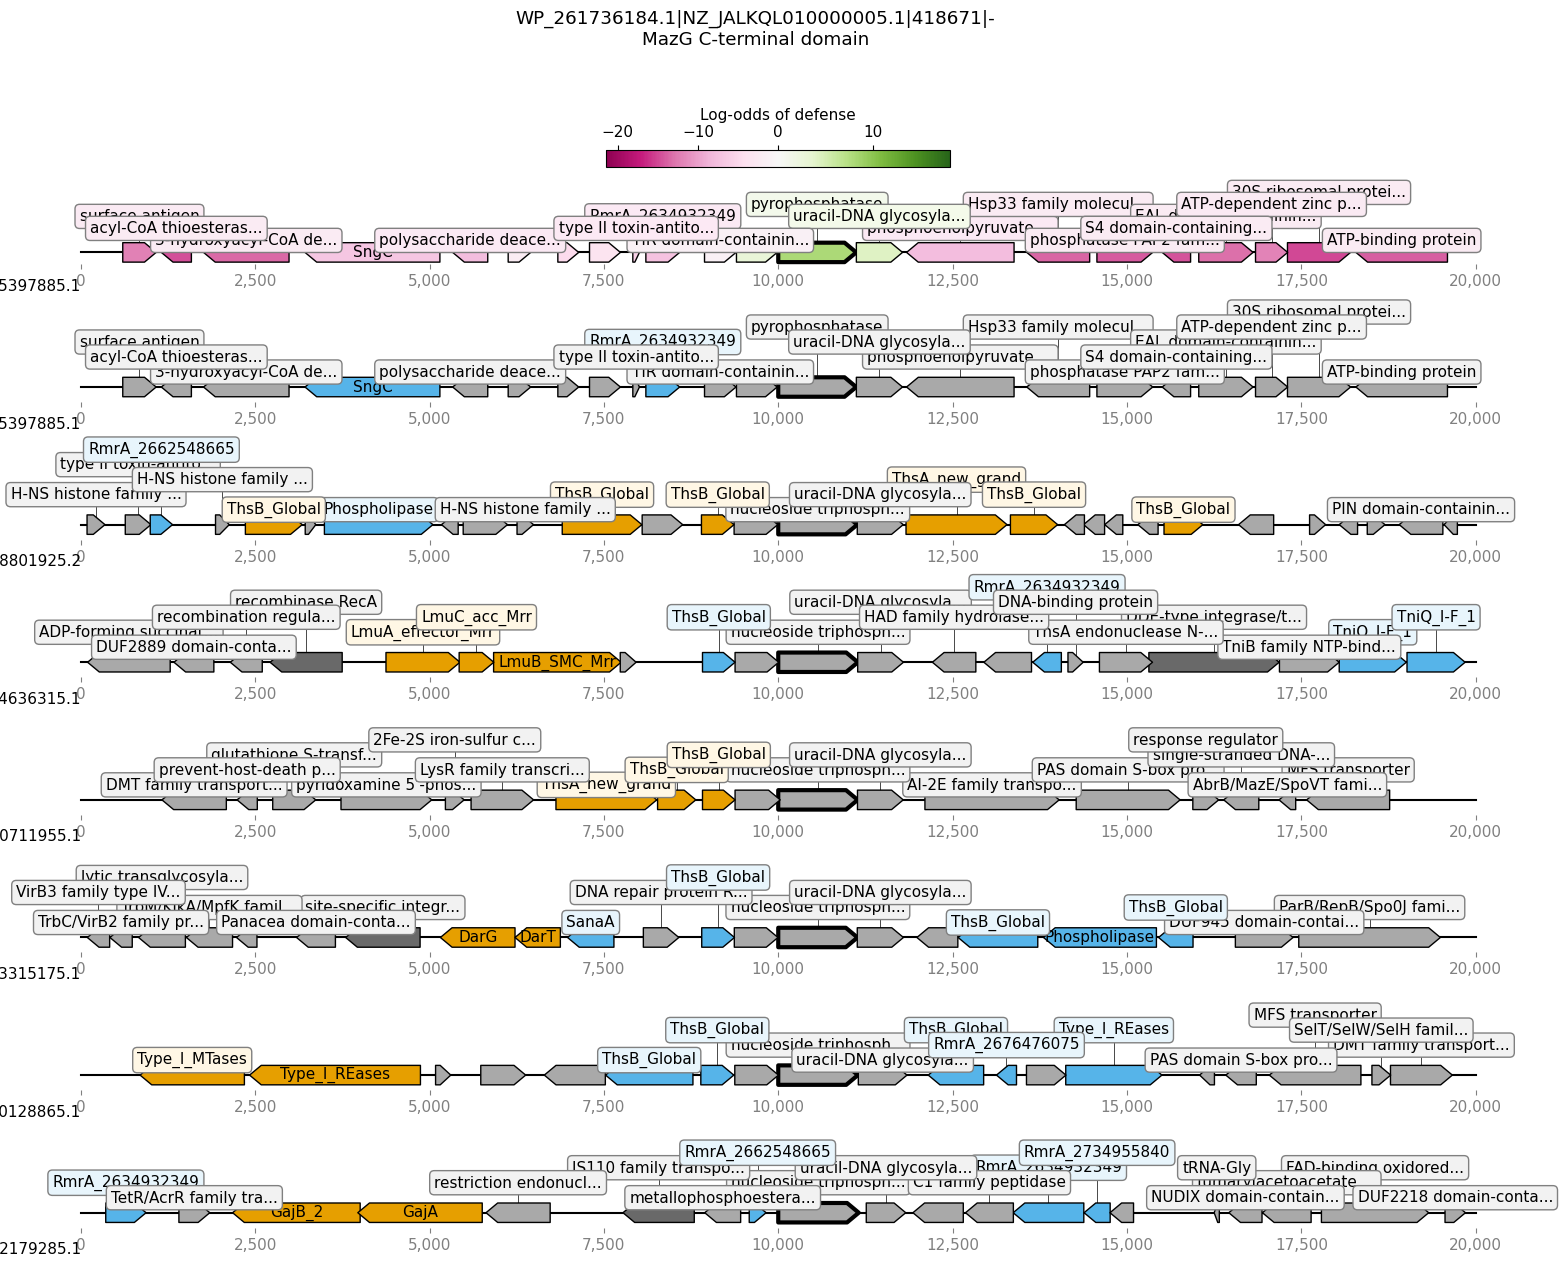

In [27]:
region_list = list()
for query, query_df in select_assemblies.groupby('query'):
    query_pred_row = select_gene_df.loc[select_gene_df['protein_context_id'] == query, :].head(1).squeeze()
    query_pfam = query_pred_row['pfam_description']
    fig, axs = plt.subplots(len(query_df) + 2, 1, figsize=(18, 2*(len(query_df)) + 2))
    # Plot predictions
    ft_file = ft_dict[query_pred_row['assembly_stub']]
    ft_df = pd.read_table(ft_file)
    center_row = (ft_df[(ft_df['product_accession'] == query_pred_row['product_accession']) & 
                        (ft_df['# feature'] == 'CDS')]
                  .head(1)
                  .squeeze())
    if (center_row['strand'] == '+'):
        region_start, region_end = center_row['start'] - region_width, center_row['start'] + region_width
    else:
        region_start, region_end = center_row['end'] - region_width, center_row['end'] + region_width
    region_df = (ft_df[(ft_df['# feature'] != 'gene') & 
                       (ft_df['start'] > region_start) & 
                       (ft_df['end'] < region_end) & 
                       (ft_df['start'] < ft_df['end']) & 
                       (ft_df['genomic_accession'] == center_row['genomic_accession'])
                      ]
                 .merge(quick_true_df, how='left', on='product_accession')
                 .merge(quick_homolog_df, how='left', on='product_accession')
                 .merge(predictions[['product_accession','start', 'mean_log_odds']], 
                        how='left', on=['product_accession','start'])
                 .reset_index(drop=True))
    region_df['center'] = region_df['product_accession'] == center_row['product_accession']
    region_df['plot_name'] = region_df.apply(get_plot_name, axis=1)
    region_df['plot_color'] = region_df.apply(get_plot_color_pred, axis=1)
    region_df['plot_start'] = region_df['start'] - region_start
    region_df['plot_start'] = [max(0, x) for x in region_df['plot_start']]
    region_df['plot_end'] = region_df['end'] - region_start
    region_df['plot_end'] = [min(2*region_width, x) for x in region_df['plot_end']]
    region_list.append(region_df)
    if center_row['strand'] == '-':
        ps = 2*region_width - region_df['plot_end']
        pe = 2*region_width - region_df['plot_start']
        region_df['plot_start'] = ps
        region_df['plot_end'] = pe
        region_df['strand'] = ['+' if (x == '-') else '-' for x in region_df['strand']]
    features = []
    for _, row in region_df.iterrows():
        if row['plot_name'] is None:
            label = None
        else:
            label = row['plot_name'] if len(row['plot_name']) < 20 else (row['plot_name'][:20] + '...')
        if row['strand'] == '+':
            strand = 1
        else:
            strand = -1
        if row['center']:
            linewidth = 3
        else:
            linewidth = 1
        color = row['plot_color']
        start = row['plot_start']
        end = row['plot_end']
        ft = GraphicFeature(start=start, end=end, strand=strand,
                            color=color, label=label, linewidth=linewidth, 
                            linecolor='black')
        features.append(ft)
    record = GraphicRecord(features = features, sequence_length=2*region_width, labels_spacing=1, 
                           feature_level_height=0)
    curr_ax = axs[0]
    record.plot(ax=curr_ax)
    curr_ax.set_xlabel(center_row['assembly'], x=0, ha='right', va='bottom')
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    plt.colorbar(sm, label='Log-odds of defense', ax=curr_ax, location='top', shrink=0.5)
    region_df['plot_color'] = region_df.apply(get_plot_color, axis=1)
    features = []
    for _, row in region_df.iterrows():
        if row['plot_name'] is None:
            label = None
        else:
            label = row['plot_name'] if len(row['plot_name']) < 20 else (row['plot_name'][:20] + '...')
        if row['strand'] == '+':
            strand = 1
        else:
            strand = -1
        if row['center']:
            linewidth = 3
        else:
            linewidth = 1
        color = row['plot_color']
        start = row['plot_start']
        end = row['plot_end']
        ft = GraphicFeature(start=start, end=end, strand=strand,
                            color=color, label=label, linewidth=linewidth, 
                            linecolor='black')
        features.append(ft)
    record = GraphicRecord(features = features, sequence_length=2*region_width, labels_spacing=1, 
                           feature_level_height=0)
    curr_ax = axs[1]
    record.plot(ax=curr_ax)
    curr_ax.set_xlabel(center_row['assembly'], x=0, ha='right', va='bottom')
    # Plot context
    for i, cluster_row in query_df.reset_index(drop=True).iterrows():
        ft_file = ft_dict[cluster_row['assembly_stub']]
        ft_df = pd.read_table(ft_file)
        center_row = (ft_df[(ft_df['product_accession'] == cluster_row['product_accession']) & 
                            (ft_df['# feature'] == 'CDS')]
                      .head(1)
                      .squeeze())
        if (center_row['strand'] == '+'):
            region_start, region_end = center_row['start'] - region_width, center_row['start'] + region_width
        else:
            region_start, region_end = center_row['end'] - region_width, center_row['end'] + region_width
        region_df = (ft_df[(ft_df['# feature'] != 'gene') & 
                           (ft_df['start'] > region_start) & 
                           (ft_df['end'] < region_end) & 
                           (ft_df['start'] < ft_df['end']) & 
                           (ft_df['genomic_accession'] == center_row['genomic_accession'])
                          ]
                          .merge(quick_true_df, how='left', on='product_accession')
                          .merge(quick_homolog_df, how='left', on='product_accession')
                          .reset_index(drop=True))
        region_df['center'] = region_df['product_accession'] == cluster_row['product_accession']
        region_df['plot_name'] = region_df.apply(get_plot_name, axis=1)
        region_df['plot_color'] = region_df.apply(get_plot_color, axis=1)
        region_df['plot_start'] = region_df['start'] - region_start
        region_df['plot_start'] = [max(0, x) for x in region_df['plot_start']]
        region_df['plot_end'] = region_df['end'] - region_start
        region_df['plot_end'] = [min(2*region_width, x) for x in region_df['plot_end']]
        region_list.append(region_df)
        if center_row['strand'] == '-':
            ps = 2*region_width - region_df['plot_end']
            pe = 2*region_width - region_df['plot_start']
            region_df['plot_start'] = ps
            region_df['plot_end'] = pe
            region_df['strand'] = ['+' if (x == '-') else '-' for x in region_df['strand']]
        features = []
        for _, row in region_df.iterrows():
            if row['plot_name'] is None:
                label = None
            else:
                label = row['plot_name'] if len(row['plot_name']) < 20 else (row['plot_name'][:20] + '...')
            if row['strand'] == '+':
                strand = 1
            else:
                strand = -1
            if row['center']:
                linewidth = 3
            else:
                linewidth = 1
            color = row['plot_color']
            start = row['plot_start']
            end = row['plot_end']
            ft = GraphicFeature(start=start, end=end, strand=strand,
                                color=color, label=label, linewidth=linewidth, 
                                linecolor='black')
            features.append(ft)
        record = GraphicRecord(features = features, sequence_length=2*region_width, labels_spacing=1, 
                               feature_level_height=0)
        curr_ax = axs[i+2]
        record.plot(ax=curr_ax)
        curr_ax.set_xlabel(center_row['assembly'], x=0, ha='right', va='bottom')
    plt.suptitle('\n'.join([query, 
                           query_pfam]))
    remove_all_clipping(fig)
    plt.savefig(f"../figures/{query}.svg", bbox_inches='tight', dpi=300)
    plt.show()
        

In [28]:
all_region_df = pd.concat(region_list)

In [29]:
all_region_df.to_csv('../data3/interim/refseq_1k_defense_regions.csv', index=False)